In [ ]:
#  1. IMPORTS
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import pandas as pd

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
base_dir = "./sac_local/"
os.makedirs(base_dir, exist_ok=True)

drive_model_path = os.path.join(base_dir, "sac_models")
os.makedirs(drive_model_path, exist_ok=True)

save_path = os.path.join(drive_model_path, "sac_hopper")
os.makedirs(save_path, exist_ok=True)

log_dir = os.path.join(base_dir, "sac_logs")
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(save_path, "best_model.zip")
final_model_path = os.path.join(save_path, "sac_hopper.zip")

if os.path.exists(best_model_path):
    # If the best model exists, use it
    model_path = best_model_path
    print(f"Using the best model: {model_path}")
elif os.path.exists(final_model_path):
    # If the best model doesn't exist but the final model does, use that
    model_path = final_model_path
    print(f"Using the final model: {model_path}")
else:
    # If neither exists, list available model files
    available_models = [f for f in os.listdir(save_path) if f.endswith('.zip')]
    if available_models:
        model_path = os.path.join(save_path, available_models[0])
        print(f"Using an available model: {model_path}")
    else:
        print("Error: No model file found!")
        model_path = None


使用最佳模型: ./sac_local/sac_models/sac_hopper/best_model.zip


Loading saved SAC model...
✅ 模型加载成功!
Running evaluation episodes to generate monitor logs...
✅ 评估完成!


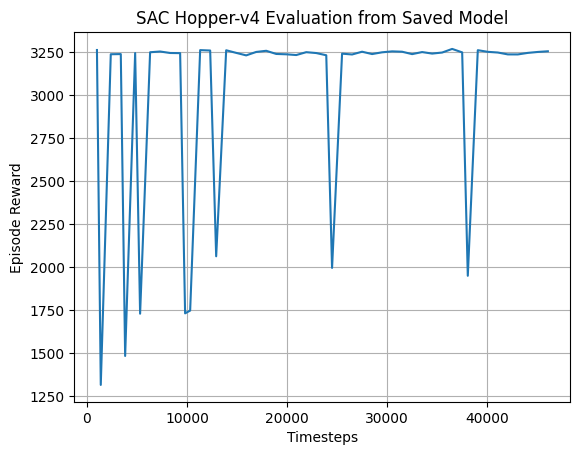

In [ ]:
# 1. Load model
print("Loading saved SAC model...")
if model_path is not None:
    try:
        model = SAC.load(model_path)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        print("Please check if the model file path is correct.")
        model = None
else:
    print("❌ No available model file found.")
    model = None

# 2. Continue only if the model was loaded successfully
if model is not None:
    # Wrap environment in Monitor for evaluation logging
    env = Monitor(gym.make("Hopper-v4"), filename=os.path.join(log_dir, "monitor.csv"))

    # 3. Run evaluation episodes to generate monitor logs
    print("Running evaluation episodes to generate monitor logs...")
    for _ in range(50):  # Run 50 episodes for more reliable statistics
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    env.close()
    print("✅ Evaluation completed successfully!")
else:
    print("❌ Cannot continue because the model failed to load.")

# 4. Plot learning curve from monitor.csv
def plot_learning_curve(log_dir, title):
    monitor_file = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(monitor_file):
        print("Monitor log not found.")
        return
    data = pd.read_csv(monitor_file, skiprows=1)
    data["timesteps"] = np.cumsum(data["l"])
    sns.lineplot(x="timesteps", y="r", data=data)
    plt.title(title)
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.grid(True)
    plt.show()

plot_learning_curve(log_dir, "SAC Hopper-v4 Evaluation from Saved Model")


In [15]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


GPU Available: False
Using device: cpu


In [16]:
#  5. EVALUATION FUNCTION
def evaluate(model, env, n_eval_episodes=10):
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    return np.mean(rewards), np.std(rewards)

def_env = gym.make("Hopper-v4")
mean_r, std_r = evaluate(model, def_env)
print(f"Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")


/opt/anaconda3/envs/hopper-sac/lib/python3.9/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/opt/anaconda3/envs/hopper-sac/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Default SAC Evaluation: Mean Reward = 3063.48, Std = 534.82


✅ Default SAC Evaluation: Mean Reward = 2954.23, Std = 604.76


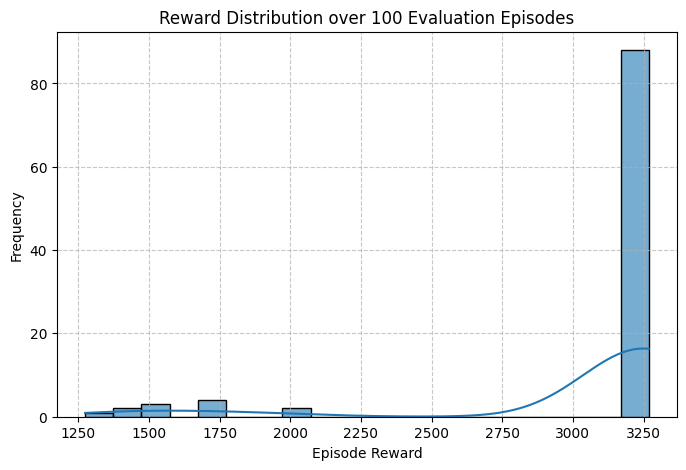

Mean: 3053.99, Std: 534.19, Min: 1273.80, Max: 3268.33


In [ ]:

def plot_reward_distribution(model, env_id="Hopper-v4", n_eval_episodes=100, deterministic=True):
    eval_env = gym.make(env_id)          
    try:
        rewards, _ = evaluate_policy(
            model, eval_env,
            n_eval_episodes=n_eval_episodes,
            return_episode_rewards=True,
            deterministic=deterministic
        )
    finally:
        eval_env.close()                

    plt.figure(figsize=(8,5))
    sns.histplot(rewards, bins=20, kde=True, edgecolor="black", alpha=0.6)
    plt.title(f"Reward Distribution over {n_eval_episodes} Evaluation Episodes")
    plt.xlabel("Episode Reward")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    print(f"Mean: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}, "
          f"Min: {np.min(rewards):.2f}, Max: {np.max(rewards):.2f}")


mean_r, std_r = evaluate_policy(model, gym.make("Hopper-v4"), n_eval_episodes=10, deterministic=True)
print(f"✅ Default SAC Evaluation: Mean Reward = {mean_r:.2f}, Std = {std_r:.2f}")
plot_reward_distribution(model, env_id="Hopper-v4", n_eval_episodes=100, deterministic=True)